In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Code for Ising with Metropolis-Hastings below ###

In [5]:
class IsingMCMC:
    def __init__(self, N, T=2.0):
        self.critical_temperature = 2.0 / np.log(1.0 + np.sqrt(2.0))
        self.temp = T
        self.N = N
        self.lattice = np.zeros([self.N, self.N])

        # Initialize accumulators to 0
        self.energy = 0
        self.energy_accum = 0
        self.energy_squared_accum = 0
        self.mag = 0
        self.mag_accum = 0
        self.mag_squared_accum = 0

        # Initialize lists to store raw data over time (aka monte carlo steps)
        self.energy_data = list()
        self.mag_data = list()

        self.mcs = 0
        self.accepted_moves = 0
        self.w = np.zeros(9)

    def initialize_system(self):
        """ Initializes a lattice of size N x N to all ones (aka spin up) """
        self.lattice = np.ones([self.N, self.N])  # all spins up
        self.mag = self.N * self.N  # sum of spins
        self.energy = -2 * self.N * self.N  # minimum energy
        self._reset_data()

        # Boltzmann factors for some reason?
        self.w[8] = np.exp(-8.0 / self.temp)
        self.w[4] = np.exp(-4.0 / self.temp)

    def _reset_data(self):
        """ Not sure why this is necessary, like many things in modern life, but here we are! """
        self.mcs = 0
        self.energy_accum = 0
        self.energy_squared_accum = 0
        self.mag_accum = 0
        self.mag_squared_accum = 0
        self.energy_data = list()
        self.mag_data = list()
        self.accepted_moves = 0

    def specific_heat(self):
        """ Computes the specific heat of the system """
        energy_squared_avg = self.energy_squared_accum / self.mcs
        energy_avg = self.energy_accum / self.mcs
        heat_capacity = energy_squared_avg - energy_avg * energy_avg
        heat_capacity /= (self.temp * self.temp)
        return heat_capacity

    def susceptibility(self):
        """ Computes the susceptibility [?] of the system """
        mag_squared_avg = self.mag_squared_accum / self.mcs
        mag_avg = self.mag_accum / self.mcs
        return (mag_squared_avg - np.square(mag_avg)) / (self.temp * self.N)

    def do_one_MC_step(self):
        """ Applies the demon algorithm to the heat bath with an embedded ising model """
        # Loop over N^2 iterations for each MC step
        for k in range(self.N * self.N):
            x, y = self._pick_random_site()
            # Flip the spin and compute the change in energy, delta E
            dE = self._compute_change_energy((x, y))

            # Accept the flip and update the lattice, energy, and magnetisation
            if dE <= 0 or self.w[int(dE)] > np.random.random():
                new_spin = -self.lattice[y, x]
                self.lattice[y, x] = new_spin
                self.accepted_moves += 1
                self.energy += dE
                self.mag += 2 * new_spin

        # Update accumulators
        self.energy_accum += self.energy
        self.energy_squared_accum += self.energy * self.energy
        self.mag_accum += self.mag
        self.mag_squared_accum += self.mag * self.mag

        # Add values to data storage lists
        self.energy_data.append(self.energy)
        self.mag_data.append(self.mag)

        self.mcs += 1

    def _compute_change_energy(self, point):
        """ Computes the energy at any point on the lattice """
        x, y = point
        nn = self._sum_nearest_neighbors(point)
        return 2 * self.lattice[y, x] * nn

    def _sum_nearest_neighbors(self, point):
        """ Computes the nearest neighbors of a point """
        x, y = point
        right = self.lattice[y, (x + 1) % self.N]
        left = self.lattice[y, (x - 1) % self.N]
        up = self.lattice[(y - 1) % self.N, x]
        down = self.lattice[(y + 1) % self.N, x]

        return right + left + up + down

    def _pick_random_site(self):
        """ Returns a random point on the lattice """
        i = np.random.randint(0, self.N)
        j = np.random.randint(0, self.N)
        return i, j

## Problem 15.12. Equilibration of the two-dimensional Ising model ##

In [6]:
# Begin by running an Ising MCMC model to equilibrum
model = IsingMCMC(N=32, T=2.0)
model.initialize_system()
for k in range(5000):
    model.do_one_MC_step()

### (a) Write a target class that uses class Ising and plots the magnetization and energy as a function of the number of Monte Carlo steps. ###

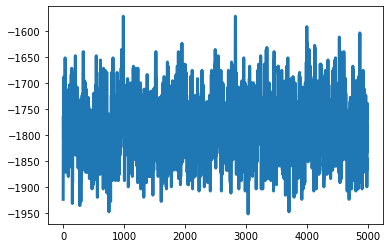

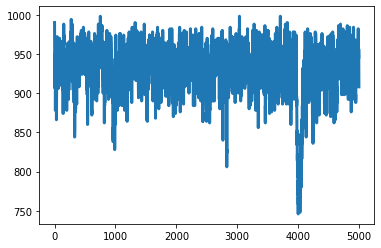

In [7]:
plt.plot(range(model.mcs), model.energy_data, lw=3)
plt.show()

plt.plot(range(model.mcs), model.mag_data, lw=3)
plt.show()

### (a) Your program should also display the mean magnetization, the energy, the specific heat, the susceptibility, and the acceptance probability when the simulation is stopped.  ###

In [23]:
# Averages such as the mean energy and the susceptibility should be 
# normalized by the number of spins so that it is easy to compare 
# systems with different values of N .
mean_energy = model.energy_accum / (model.N**2 * model.mcs)
mean_mag = model.mag_accum / (model.N**2 * model.mcs)
specific_heat = model.specific_heat()
susceptibility = model.susceptibility()
accepted_prob = model.accepted_moves / (model.N**2 * model.mcs)

print(f'Mean energy: {mean_energy:010}')
print(f'Mean magnetisation: {mean_mag:010}')
print(f'Specific Heat: {specific_heat:010}')
print(f'Susceptibility: {susceptibility:010}')
print(f'Accepted Prob: {accepted_prob:010}')

Mean energy: -1.7456375
Mean magnetisation: 0.910104296875
Specific Heat: 724.3422310400056
Susceptibility: 14.973668277498291
Accepted Prob: 0.079335546875


### (a) Estimate the time needed to equilibrate the system given that all the spins are initially up. ### 

### (b) Visually determine if the spin configurations are “ordered” or “disordered” at T = 2 after equilibrium has been established.  ###

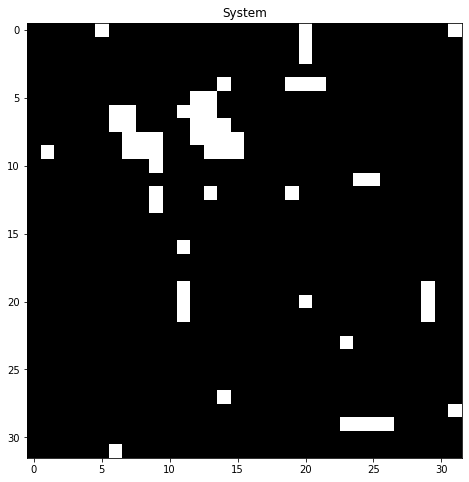

In [25]:
fig, ax = plt.subplots(figsize=(10, 8))
im = ax.imshow(model.lattice, cmap='Greys')
ax.set_title('System')
plt.show()